In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/the-future-crop-challenge/pr_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_train.parquet
/kaggle/input/the-future-crop-challenge/sample_submission.csv
/kaggle/input/the-future-crop-challenge/soil_co2_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_train.parquet
/kaggle/input/the-future-crop-challenge/tasmin_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/tasmax_wheat_train.parquet
/kaggle/input/the-future-crop-challenge/rsds_maize_test.parquet
/kaggle/input/the-future-crop-challenge/soil_co2_maize_test.parquet
/kaggle/input/the-future-crop-challenge/train_solutions_maize.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_test.parquet
/kaggle/input/the-future-crop-challenge/tas_wheat_test.parquet
/kaggle/input/the-future-crop-challenge/tasmax_maize_test.parquet
/kaggle/input/the-future-crop-challenge/pr_maize_train.parquet
/kaggle/input/the-fu

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

def load_data(crop: str, mode: str="train"):
    base_path = "/kaggle/input/the-future-crop-challenge"

    tasmax = pd.read_parquet(f"{base_path}/tasmax_{crop}_{mode}.parquet")
    tasmin = pd.read_parquet(f"{base_path}/tasmin_{crop}_{mode}.parquet")
    pr = pd.read_parquet(f"{base_path}/pr_{crop}_{mode}.parquet")
    rsds = pd.read_parquet(f"{base_path}/rsds_{crop}_{mode}.parquet")
    soil_co2 = pd.read_parquet(f"{base_path}/soil_co2_{crop}_{mode}.parquet")

    target = None
    if mode == "train":
        target = pd.read_parquet(f"{base_path}/train_solutions_{crop}.parquet")

    return {
        'tasmax': tasmax,
        'tasmin': tasmin,
        'pr': pr,
        'rsds': rsds,
        'soil_co2': soil_co2,
        'target': target,
    }

wheat_train = load_data("wheat", "train")


In [7]:
wheat_train['tasmax'].head()

,crop,year,lon,lat,variable,0,1,2,3,4,...,230,231,232,233,234,235,236,237,238,239
ID,,,,,,,,,,,,,,,,,,,,,
1040990,wheat,381.0,-123.25,44.75,tasmax,23.049103,23.068085,22.456024,22.436310,26.780334,...,12.934174,15.239380,16.033478,15.467102,15.350494,18.074463,22.921326,22.485321,19.365509,15.624176
1040991,wheat,381.0,-123.25,45.25,tasmax,22.813080,22.352630,20.821625,21.305786,25.567230,...,12.328430,14.570068,14.932007,14.576843,15.078705,17.318848,21.731415,21.320953,16.874084,14.049622
1040992,wheat,381.0,-123.25,45.75,tasmax,21.476654,20.339020,18.736450,19.543915,23.196594,...,10.175903,12.706146,13.080719,12.247559,14.706970,15.665314,19.503418,18.673645,14.232849,11.914795
1040993,wheat,381.0,-122.75,44.75,tasmax,21.919190,22.533356,22.602478,22.221985,27.705597,...,12.470215,15.631287,15.642731,15.533295,14.302979,19.089752,23.392914,23.677734,20.930786,16.635345
1040994,wheat,381.0,-122.75,45.25,tasmax,24.298248,22.923706,22.342560,22.448639,27.233460,...,13.172394,16.275055,16.216248,15.754333,16.164154,18.457214,24.019226,23.301483,19.229675,15.773041


In [8]:
wheat_train['target'].head()

,yield
ID,
1040990,4.775
1040991,4.874
1040992,4.701
1040993,4.848
1040994,5.178


In [9]:
def aggregate_daily_data(df):
    numeric_df = df.iloc[:, 4:].apply(pd.to_numeric, errors='coerce')
    return numeric_df.agg(['mean', 'max', 'min', 'std'], axis=1)

tasmax_agg_wheat = aggregate_daily_data(wheat_train['tasmax'])
tasmin_agg_wheat = aggregate_daily_data(wheat_train['tasmin'])
pr_agg_wheat = aggregate_daily_data(wheat_train['pr'])
rsds_agg_wheat = aggregate_daily_data(wheat_train['rsds'])

tasmax_agg_wheat.columns = [f'tasmax_{col}' for col in tasmax_agg_wheat.columns]
tasmin_agg_wheat.columns = [f'tasmin_{col}' for col in tasmin_agg_wheat.columns]
pr_agg_wheat.columns     = [f'pr_{col}' for col in pr_agg_wheat.columns]
rsds_agg_wheat.columns   = [f'rsds_{col}' for col in rsds_agg_wheat.columns]

features_wheat = pd.concat([tasmax_agg_wheat, tasmin_agg_wheat, pr_agg_wheat, rsds_agg_wheat, wheat_train['soil_co2']], axis=1)
target_wheat = wheat_train['target']


In [10]:
features_wheat

,tasmax_mean,tasmax_max,tasmax_min,tasmax_std,tasmin_mean,tasmin_max,tasmin_min,tasmin_std,pr_mean,pr_max,...,rsds_min,rsds_std,crop,year,lon,lat,texture_class,real_year,co2,nitrogen
ID,,,,,,,,,,,,,,,,,,,,,
1040990,13.355497,32.060333,-1.137970,5.835151,4.379208,13.177643,-9.583160,3.859072,0.000087,0.000642,...,2.863686,74.257505,wheat,381.0,-123.25,44.75,9.0,1982,340.79,102.824997
1040991,12.946270,31.235260,-2.419830,5.480161,4.064107,13.372467,-10.941071,3.804593,0.000091,0.000710,...,4.936584,72.836953,wheat,381.0,-123.25,45.25,9.0,1982,340.79,102.824997
1040992,11.639446,30.058044,-3.342865,5.185817,3.127993,12.391998,-12.929657,3.851878,0.000104,0.000747,...,7.091615,70.506507,wheat,381.0,-123.25,45.75,9.0,1982,340.79,102.824997
1040993,12.958268,32.426056,-1.801300,6.211627,3.691531,13.634766,-11.055267,4.087084,0.000095,0.000717,...,2.978635,74.356077,wheat,381.0,-122.75,44.75,9.0,1982,340.79,102.824997
1040994,13.558769,33.562530,-2.606445,6.062246,4.361445,14.687836,-11.129517,4.034662,0.000075,0.000662,...,4.243568,73.267877,wheat,381.0,-122.75,45.25,9.0,1982,340.79,102.824997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319732,19.234315,32.111877,7.748901,4.270984,7.449507,19.863160,-1.679108,4.320872,0.000020,0.000435,...,31.529875,67.787351,wheat,419.0,152.25,-30.25,9.0,2020,414.89,40.074001
1319733,20.447826,33.240480,9.090790,4.286206,8.014718,19.485382,-1.769623,4.346878,0.000017,0.000489,...,41.781296,64.320139,wheat,419.0,152.25,-29.25,9.0,2020,414.89,40.074001
1319734,21.666283,34.099396,10.957092,4.263714,9.470694,20.540863,-0.497345,4.313733,0.000017,0.000420,...,50.577038,64.863663,wheat,419.0,152.25,-28.75,9.0,2020,414.89,40.074001


In [10]:
target_wheat

,yield
ID,
1040990,4.775
1040991,4.874
1040992,4.701
1040993,4.848
1040994,5.178
...,...
1319732,1.418
1319733,1.653
1319734,1.271


In [11]:
numeric_features_wheat = features_wheat.select_dtypes(include=[np.number])

scaler_wheat = StandardScaler()
features_scaled_wheat = scaler_wheat.fit_transform(numeric_features_wheat)


In [12]:
year_series = wheat_train['tasmax']['year']
val_year = year_series.max()  # Should be 2020
print(f"Using year {val_year} for validation.")

Using year 419.0 for validation.


In [14]:
val_mask = (year_series == val_year)
X_train = features_scaled_wheat[~val_mask]
X_val = features_scaled_wheat[val_mask]
y_train = target_wheat[~val_mask].values.ravel()
y_val = target_wheat[val_mask].values.ravel()

In [15]:
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# from tqdm import tqdm

# model = RandomForestRegressor(
#     n_estimators=1,
#     warm_start=True,
#     random_state=42
# )

# for i in tqdm(range(1, 101), desc="Training Random Forest"):
#     model.set_params(n_estimators=i)
#     model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [16]:
from sklearn.metrics import mean_squared_error, r2_score
y_val_pred = model.predict(X_val)

rmse = mean_squared_error(y_val, y_val_pred, squared=False)
r2 = r2_score(y_val, y_val_pred)

print(f"Random Forest Validation RMSE (2020): {rmse:.4f}")
print(f"Random Forest Validation R2 (2020): {r2:.4f}")

Random Forest Validation RMSE (2020): 0.7963
Random Forest Validation R2 (2020): 0.8070


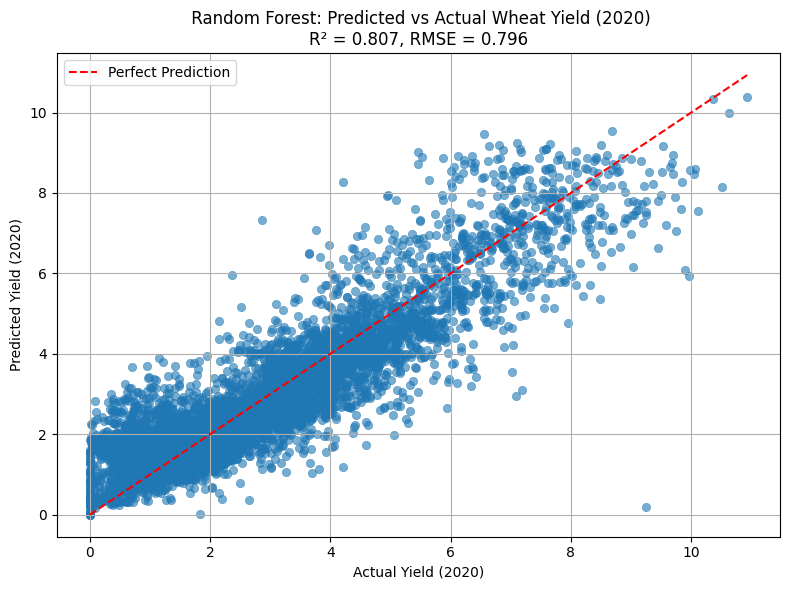

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.6, edgecolor=None)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield (2020)")
plt.ylabel("Predicted Yield (2020)")
plt.title(f" Random Forest: Predicted vs Actual Wheat Yield (2020)\nR² = {r2:.3f}, RMSE = {rmse:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


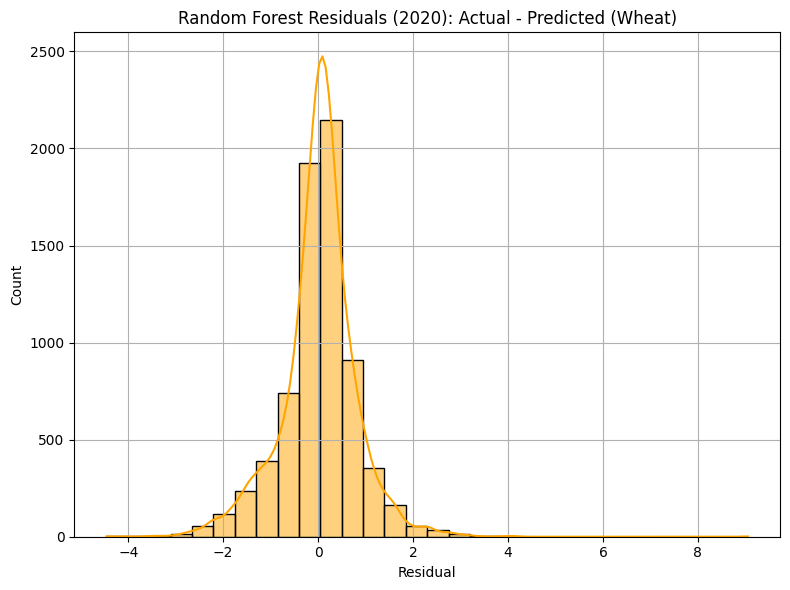

In [22]:
# Residuals (Actual - Predicted)
residuals = y_val - y_val_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='orange')
plt.title("Random Forest Residuals (2020): Actual - Predicted (Wheat)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# Load test data and do the same
wheat_test = load_data("wheat", "test")

tasmax_agg_test = aggregate_daily_data(wheat_test['tasmax'])
tasmax_agg_test.columns = [f'tasmax_{col}' for col in tasmax_agg_test.columns]

tasmin_agg_test = aggregate_daily_data(wheat_test['tasmin'])
tasmin_agg_test.columns = [f'tasmin_{col}' for col in tasmin_agg_test.columns]

pr_agg_test = aggregate_daily_data(wheat_test['pr'])
pr_agg_test.columns = [f'pr_{col}' for col in pr_agg_test.columns]

rsds_agg_test = aggregate_daily_data(wheat_test['rsds'])
rsds_agg_test.columns = [f'rsds_{col}' for col in rsds_agg_test.columns]

features_test = pd.concat([tasmax_agg_test, tasmin_agg_test, pr_agg_test, rsds_agg_test, wheat_test['soil_co2']], axis=1)

numeric_features_test = features_test.select_dtypes(include=[np.number])

numeric_features_test = numeric_features_test.dropna()

features_scaled_test = scaler_wheat.transform(numeric_features_test)
test_ids = numeric_features_test.index

predictions = model.predict(features_scaled_test)
pred_results = pd.DataFrame({
    "ID": test_ids,
    "Predicted_Yield": predictions
})
pred_results.head()

,ID,Predicted_Yield
0,1319737,4.94140
1,1319738,4.91789
2,1319739,4.93794
3,1319740,5.09550
4,1319741,4.95361


In [17]:
# from sklearn.metrics import mean_squared_error

# y_pred = model.predict(X_val)
# rmse = mean_squared_error(y_val, y_pred, squared=False)
# print(f"RMSE: {rmse}")

RMSE: 0.6230091066983213


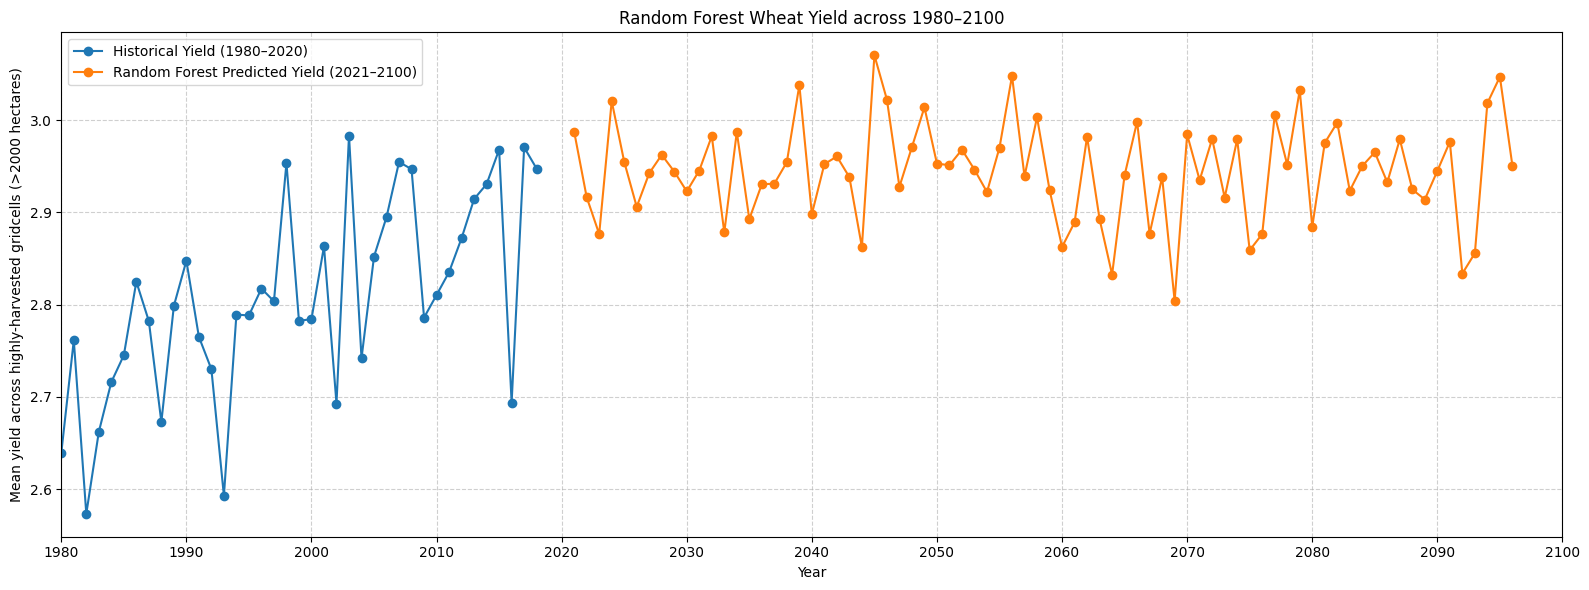

In [26]:
# Step 0: Year decoder function
def decode_year(encoded_year):
    return encoded_year - 381 + 1980

# Step 1: Random Forest predictions (2021–2100), with decoded years
rf_years_decoded = decode_year(wheat_test['tasmax'].loc[numeric_features_test.index, 'year']).astype(int)

rf_pred_df = pd.DataFrame({
    "Year": rf_years_decoded,
    "Yield": predictions
}, index=numeric_features_test.index)

rf_future = rf_pred_df[(rf_pred_df["Year"] >= 2021) & (rf_pred_df["Year"] <= 2100)]
rf_future_avg = rf_future.groupby("Year", as_index=False)["Yield"].mean().rename(columns={"Yield": "Yield_pred"})

# Step 2: Historical yield (1980–2020), reuse val_mask and y_train/y_val from earlier RF setup
encoded_years = wheat_train["tasmax"]["year"]

# Decode training and validation years
train_years = decode_year(encoded_years[~val_mask].astype(int))
val_years = decode_year(encoded_years[val_mask].astype(int))

historical_years_all = pd.concat([train_years.reset_index(drop=True), val_years.reset_index(drop=True)])
historical_yields_all = np.concatenate([y_train, y_val])

historical_df = pd.DataFrame({
    "Year": historical_years_all,
    "Yield_hist": historical_yields_all
})
historical_avg = historical_df.groupby("Year", as_index=False)["Yield_hist"].mean()

# Step 3: Merge into full 1980–2100 DataFrame
all_years = pd.DataFrame({"Year": range(1980, 2101)})
historical_avg["Year"] = historical_avg["Year"].astype(int)
rf_future_avg["Year"] = rf_future_avg["Year"].astype(int)

plot_df = all_years.merge(historical_avg, on="Year", how="left")
plot_df = plot_df.merge(rf_future_avg, on="Year", how="left")

# Step 4: Plot Random Forest line (same style as XGBoost version)
plt.figure(figsize=(16, 6))
plt.plot(plot_df["Year"][plot_df["Yield_hist"].notna()],
         plot_df["Yield_hist"].dropna(),
         marker="o", color="tab:blue", label="Historical Yield (1980–2020)")

plt.plot(plot_df["Year"][plot_df["Yield_pred"].notna()],
         plot_df["Yield_pred"].dropna(),
         marker="o", color="tab:orange", label="Random Forest Predicted Yield (2021–2100)")

plt.xlabel("Year")
plt.ylabel("Mean yield across highly-harvested gridcells (>2000 hectares)")
plt.title("Random Forest Wheat Yield across 1980–2100")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(1980, 2100)
plt.xticks(range(1980, 2101, 10))
plt.legend()
plt.tight_layout()
plt.show()


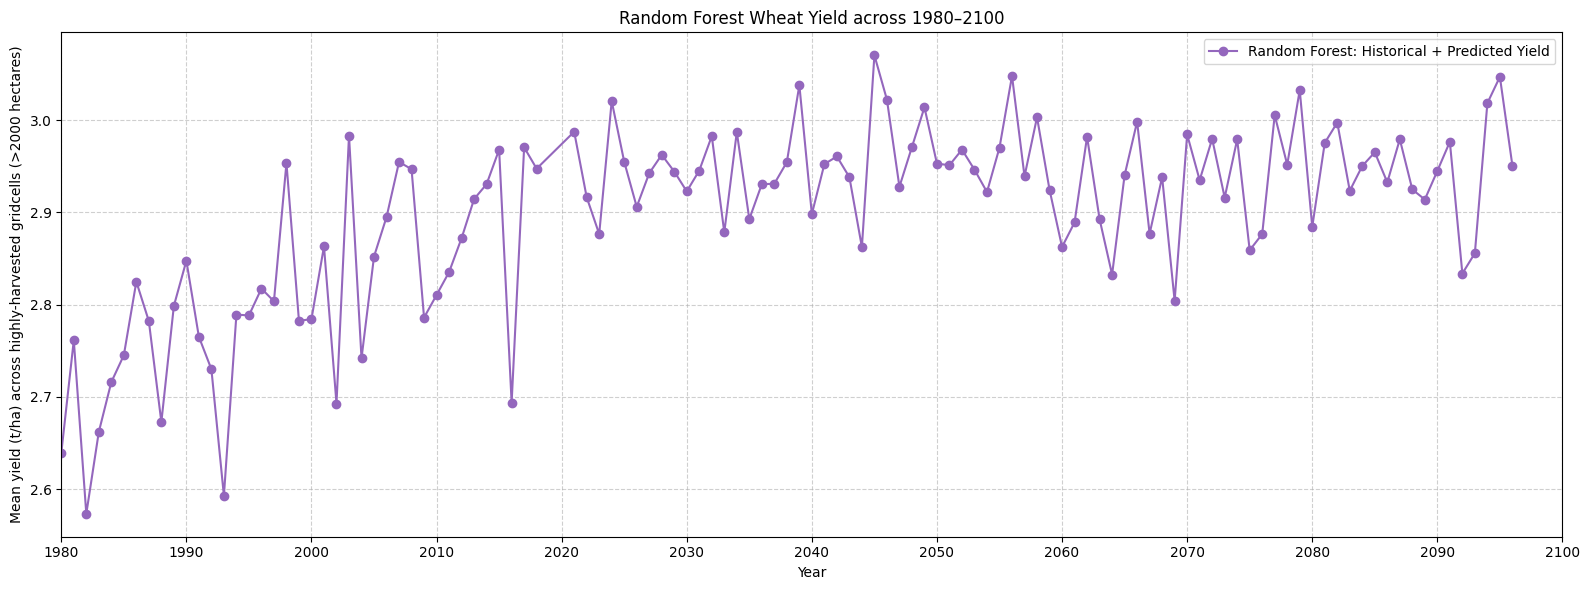

In [28]:
# Combine historical and predicted yields into one continuous series
combined_yield = pd.concat([
    plot_df.set_index("Year")["Yield_hist"].dropna(),
    plot_df.set_index("Year")["Yield_pred"].dropna()
])

# Plot the full timeline
plt.figure(figsize=(16, 6))
plt.plot(combined_yield.index, combined_yield.values, marker="o", color="tab:purple", label="Random Forest: Historical + Predicted Yield")
plt.xlabel("Year")
plt.ylabel("Mean yield (t/ha) across highly-harvested gridcells (>2000 hectares)")
plt.title("Random Forest Wheat Yield across 1980–2100")
plt.grid(True, linestyle="--", alpha=0.6)
plt.xlim(1980, 2100)
plt.xticks(range(1980, 2101, 10))
plt.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_33/3437600465.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=importances[top_idx], y=features[top_idx], ci=None)


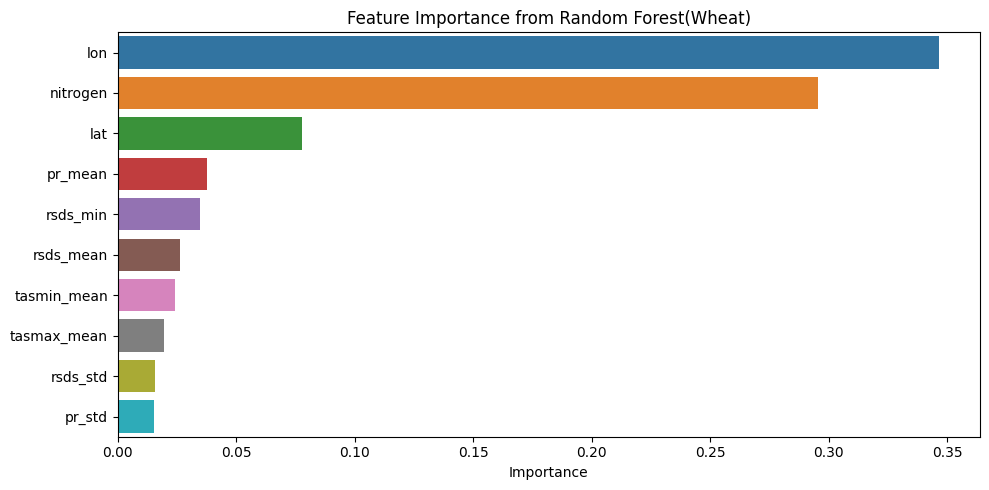

In [32]:
# Feature importance from XGBoost
importances = model.feature_importances_
features = numeric_features_wheat.columns
sorted_idx = np.argsort(importances)[::-1]  # Descending order
top_idx = sorted_idx[:10]

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[top_idx], y=features[top_idx], ci=None)
plt.title("Feature Importance from Random Forest(Wheat)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


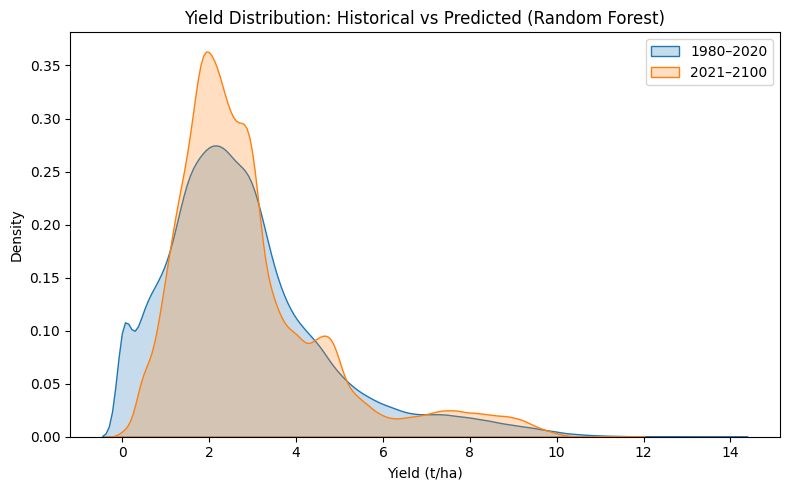

In [33]:
# Prepare historical and predicted yield DataFrames (same structure as XGBoost version)
historical_rf_df = historical_df[["Year", "Yield_hist"]].rename(columns={"Yield_hist": "Yield"})
historical_rf_df = historical_rf_df[(historical_rf_df["Year"] >= 1980) & (historical_rf_df["Year"] <= 2020)]

future_rf_df = rf_pred_df[rf_pred_df["Year"] >= 2021]

# KDE plot for yield distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(data=historical_rf_df, x="Yield", label="1980–2020", fill=True)
sns.kdeplot(data=future_rf_df, x="Yield", label="2021–2100", fill=True)
plt.title("Yield Distribution: Historical vs Predicted (Random Forest)")
plt.xlabel("Yield (t/ha)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()